In [2]:
# install libraries
# !pip install hazm
# !pip install pandas
# !pip install gensim
# !pip install matplotlib
# !pip install seaborn
# !pip install sklearn

In [1]:
# libraries
import codecs
import os
import json
import tqdm
import random
from collections import Counter
from nltk import FreqDist
import pandas as pd
import numpy as np
import itertools
from hazm import *
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn import metrics
import pandas as pd
import pickle

C:\Users\Mahdi\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
import json

DIRNAME = '../new-dataset-with-category'
data = []
for i in range(1, 31):
    with open(f'{DIRNAME}/namnak-{i}.json', 'r', encoding="utf-8") as f:
        data.extend(json.loads(f.read()))

In [3]:
len(data)

7053

# Fasttext Embedding

In [4]:
class FastTextEmbedingModel:
    def __init__(self):
        self.ft_model = FastText.load('../models/_fasttext.model')
        self.normalizer = Normalizer()
        stopwords = [self.normalizer.normalize(x.strip()) for x in
                     codecs.open('../stopwords/stopwords.txt', 'r', 'utf-8').readlines()]
        custom_stop_words = [self.normalizer.normalize(x.strip()) for x in
                             codecs.open('../stopwords/custom_stopwords.txt', 'r', 'utf-8').readlines()]
        self.total_stop_words = custom_stop_words + stopwords
        
    def get_doc_embeding(self, doc):
        doc_title, doc_text = self.get_text_and_title(doc)
        return self.__get_doc_embeding(doc_title, doc_text)

    def __get_doc_embeding(self, doc_title, doc_text):
        return ((self.get_text_embeding(doc_text) * 22) + self.get_text_embeding(doc_title)) / 23
    
    def get_text_embeding(self, text):
        tokens = [_ for _ in word_tokenize(self.normalizer.normalize(text)) if _ not in self.total_stop_words]
        emb = np.zeros(self.ft_model.wv.vector_size)
        for token in tokens:
            emb += self.ft_model.wv[token]
        emb /= len(tokens)
        return emb
    
    def get_text_and_title(self, doc):
        return doc['title'], doc['abstract'] + " " + " ".join(doc['paragraphs'])

In [5]:
fasttext_embeding_model = FastTextEmbedingModel()

# Prepare Documents Embedding

In [6]:
category_dictionary = {
    'سلامت روان' : 0,
    'دهان و دندان' : 1,
    'پوست و مو' : 2,
    'تغذیه' : 3,
    'سلامت خانواده' : 4,
    'سلامت جنسی' : 5,
    'پیشگیری و بیماریها' : 6
}

In [7]:
doc_num = {_:0 for _ in category_dictionary.values()}
doc_num_threshold = 350

X_train = list()
Y_test = list()
shuffeled_data = random.sample(data ,len(data))
doc_titles = list()
final_data = list()

for i in tqdm.tqdm(range(0, len(shuffeled_data))):
    doc = shuffeled_data[i]
    if doc['category'] in category_dictionary.keys() and doc_num[category_dictionary[doc['category']]] < doc_num_threshold:
        doc_num[category_dictionary[doc['category']]] += 1
        Y_test.append(category_dictionary[doc['category']])
        doc_embeding = fasttext_embeding_model.get_doc_embeding(doc)
        X_train.append(doc_embeding / np.linalg.norm(doc_embeding))
        doc_titles.append(doc['title'])
        final_data.append({'link' : shuffeled_data[i]['link'], 'label' : category_dictionary[doc['category']],
                          'title' : shuffeled_data[i]['title'],
                           'embedding' : list(doc_embeding / np.linalg.norm(doc_embeding))})

100%|█████████████████████████████████████████████████████████████████████████████| 7053/7053 [00:20<00:00, 350.77it/s]


# K-means Clustering

In [8]:
kmeans = KMeans(n_clusters=7, n_init=50, max_iter=1000, tol=1e-8).fit(X_train)

In [9]:
Y_predicted = kmeans.predict(X_train)

In [10]:
for i in range(len(Y_predicted)):
    final_data[i]['cluster'] = int(Y_predicted[i])

In [11]:
for i in range(0,7):
    print(f'cluster{i} : {Y_predicted.tolist().count(i)}')

cluster0 : 156
cluster1 : 531
cluster2 : 437
cluster3 : 266
cluster4 : 431
cluster5 : 381
cluster6 : 232


In [14]:
with open(f'../models/classification-clustering/clustering_embedding.json', 'w', encoding="utf-8") as f:
    json.dump(final_data, f)

In [15]:
pickle.dump(kmeans, open("../models/classification-clustering/kmeans.pkl", "wb"))

# Load data and Kmeans model

In [440]:
kmeans = pickle.load(open("kmeans.pkl", "rb"))

with open('../models/clustering_embedding.json', 'r', encoding="utf-8") as f:
            all_data = json.loads(f.read())
df = pd.DataFrame(all_data)

In [441]:
query = 'دندانم بسیار درد می‌کند و نیاز به لمینت دارم.'
query_embeding = fasttext_embeding_model.get_text_embeding(query)

predicted_cluster = kmeans.predict([query_embeding / np.linalg.norm(query_embeding)])[0]

In [442]:
df_same_cluster = df[df['cluster'] == predicted_cluster].reset_index(drop=True)

In [443]:
def cosine_similarity(vector_1: np.ndarray, vector_2: np.ndarray) -> float:
        return np.dot(vector_1, vector_2)/(np.linalg.norm(vector_1) *
                                          np.linalg.norm(vector_2))

In [444]:
ten_most_similar_index = list(np.argsort(df_same_cluster.apply(lambda x: cosine_similarity(x['embedding'], query_embeding),
                                                          axis=1))[-10:][::-1])

In [445]:
df_same_cluster

link  label  \
0                   https://namnak.com/ارتودنسی.p68056      1   
1          https://namnak.com/teeth-night-guard.p79755      1   
2    https://namnak.com/stress-effects-on-teeth.p83218      1   
3     https://namnak.com/مسواک-خوب-چه-جنسی-دارد.p26055      1   
4    https://namnak.com/dental-treatment-breastfeed...      1   
..                                                 ...    ...   
266  https://namnak.com/مشاوره-مشکلات-فک-در-کودکان....      1   
267                https://namnak.com/ژنژیویت-لثه.p145      1   
268           https://namnak.com/مسواک-در-توالت.p44740      1   
269                  https://namnak.com/ورم-لثه.p68532      1   
270                      https://namnak.com/لکه.p65389      1   

                                                 title  \
0               بعد از ارتودنسی چی بخوریم و چی نخوریم؟   
1      نایت گارد دندان چیست و چه مزایایی دارد؟ + انواع   
2                آسیب باورنکردنی استرس به دهان و دندان   
3    راهنمای خرید مسواک خوب ؛ مسواک خوب باید نرم با...   
4            قبل رفتن به دندانپزشکی در شیردهی بخوانید    
..                                                 ...   
266    بهترین سن برای مشاوره در زمینه مشکلات فک کودکان   
267  علت اصلی التهاب یا ژنژیویت لثه و 17 درمان خانگ...   
268                  هرگز مسواکتان را در توالت نگذارید   
269  درمان ورم لثه خیلی فوری در خانه + علل و درمان ...   
270           بارز ترین علت لکه ی قهوه ای بر روی دندان   

                                             embedding  cluster  
0    [0.06149082164691316, -0.003283333254271085, 0...        3  
1    [0.09177046002953784, 0.05680151792929636, 0.0...        3  
2    [0.0975627874916294, 0.050297727094031214, -0....        3  
3    [0.09459129808058582, -0.004582718107437157, 0...        3  
4    [0.07403445713199504, 0.07636576778403796, 0.0...        3  
..                                                 ...      ...  
266  [0.05074244891767694, 0.09282708687607068, -0....        3  
267  [0.10290280205297393, 0.009270206234212142, 0....        3  
268  [0.0859122494023674, 0.0032163258586707763, 0....        3  
269  [0.10747896637480571, 0.00830174372522736, 0.0...        3  
270  [0.08508310543408008, 0.08337532759797314, 0.0...        3  

[271 rows x 5 columns]

In [446]:
result = []
for i in ten_most_similar_index:
    result.append({'title' : df_same_cluster['title'][i], 'link' : df_same_cluster['link'][i]})

# Samples from clusters

In [260]:
def samples_from_cluster(doc_titles, predicted_list, category_id, k=5):
    c = 0
    ls = []
    for predicted_category, doc_title in zip(predicted_list, doc_titles):
        if predicted_category == category_id:
            ls.append(doc_title)
            c += 1
        else:
            continue
        if c == k:
            break
    return ls

In [261]:
samples_from_cluster(doc_titles, Y_predicted, 4)

['درمان کمبود آهن با این سبزیجات آهن دار',
 'خواص ، مضرات و اندازه مصرف کندر برای همه + روش خوردن کندر',
 'افزایش و تقویت میل جنسی با گیاه دامیانا',
 'هیچ وقت این موقع روز آجیل نخور',
 'خواص باورنکردنی گوشت غاز برای سلامت و درمان + عوارض']

In [262]:
samples_from_cluster(doc_titles, Y_predicted, 6)

['دندان شما چه زمانی قاتل شما می شوند؟',
 'فواید مسواک زدن شگفت زده تان می کند + تمام خواص',
 'تاثیر دندان خراب بر درد معده',
 'عوارضی که هیچ کس قبل ارتودنسی به شما نمیگوید',
 'دهان شویه یا خمیر دندان، کدام بهتر است؟']

# Calculate RSS

In [263]:
print(f'RSS = {kmeans.inertia_}')

RSS = 241.48435766863528


# Calculate Davies Bouldin Score

In [264]:
davies_bouldin_score(X_train, Y_predicted)

2.238822904226225

# Calculate Silhouette Score

In [265]:
metrics.silhouette_score(X_train, Y_predicted)

0.12273736852709705

# Calculate Purity Score

In [18]:
def purity_score(y_true, y_pred):
    contin_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contin_matrix, axis=0)) / np.sum(contin_matrix) 

In [19]:
purity_score(Y_test, Y_predicted)

0.5887428101889893

# Save metrics

In [20]:
result = {}
result['RSS'] = kmeans.inertia_
result['Davies Bouldin Score'] = davies_bouldin_score(X_train, Y_predicted)
result['Silhouette Score'] = metrics.silhouette_score(X_train, Y_predicted)
result['Purity Score'] = purity_score(Y_test, Y_predicted)
with open(f'../models/classification-clustering/clustering_result.json', 'w', encoding="utf-8") as f:
    json.dump(result, f)

# Affect of K on RSS and Determine optimal K

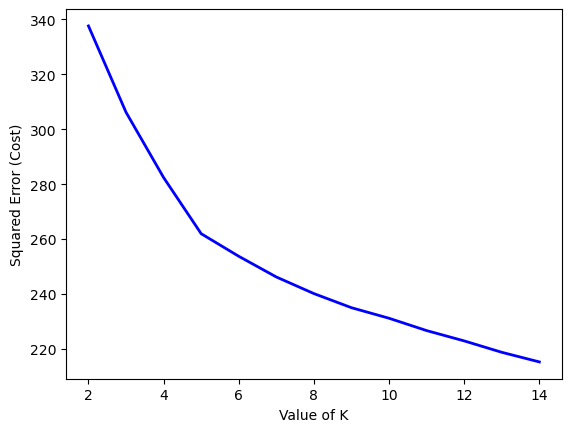

In [238]:
cost =[]
for i in range(2, 15):
    km = KMeans(n_clusters=i, n_init=10, max_iter=500, tol=1e-8).fit(X_train)
    cost.append(km.inertia_)    
 
plt.plot(range(2, 15), cost, color ='b', linewidth ='2')
plt.xlabel("Value of K")
plt.ylabel("Squared Error (Cost)")
plt.show()

# Plot Clusters Using PCA

In [239]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train)

pca_x = pca_result[:,0]
pca_y = pca_result[:,1] 

## K-means Clusters

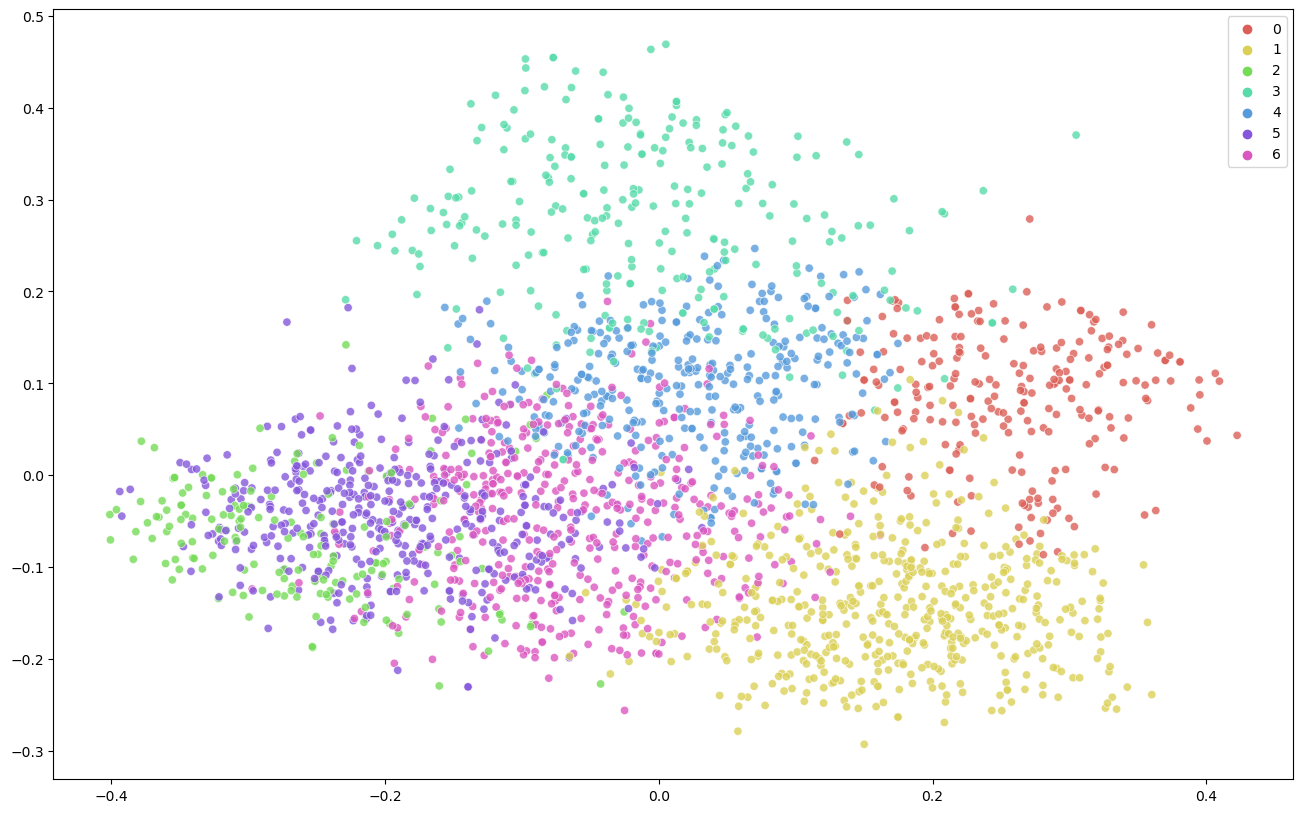

In [240]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=Y_predicted,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)
plt.show()

## Documents True Classes

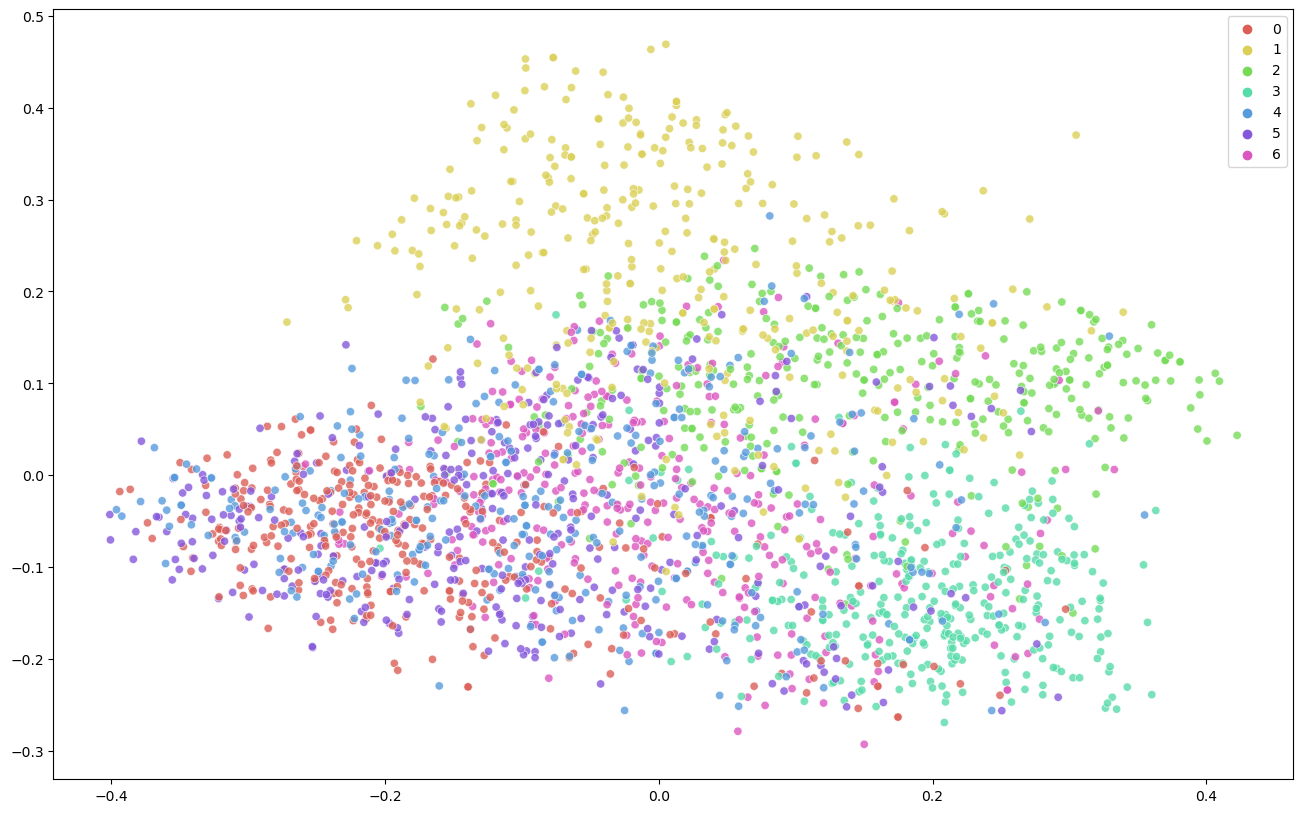

In [241]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=Y_test,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)
plt.show()

# 3D PCA plot

In [242]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train)

pca_x = pca_result[:,0]
pca_y = pca_result[:,1]
pca_z = pca_result[:,2]

## K-means Clusters

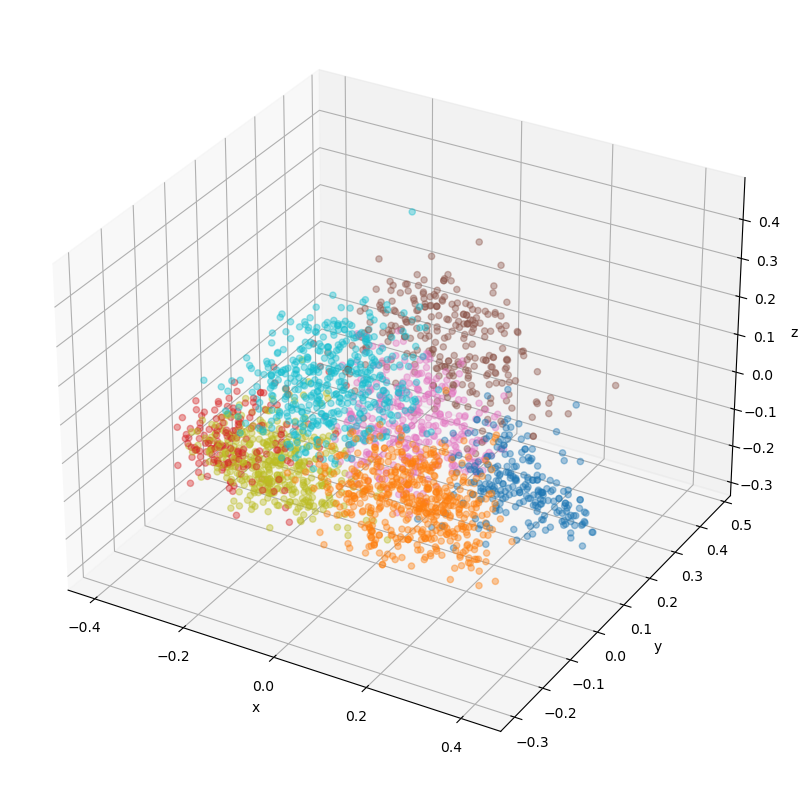

In [243]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_x, 
    ys=pca_y, 
    zs=pca_z, 
    c=Y_predicted, 
    cmap='tab10',
    alpha=0.4
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Documents True Classes

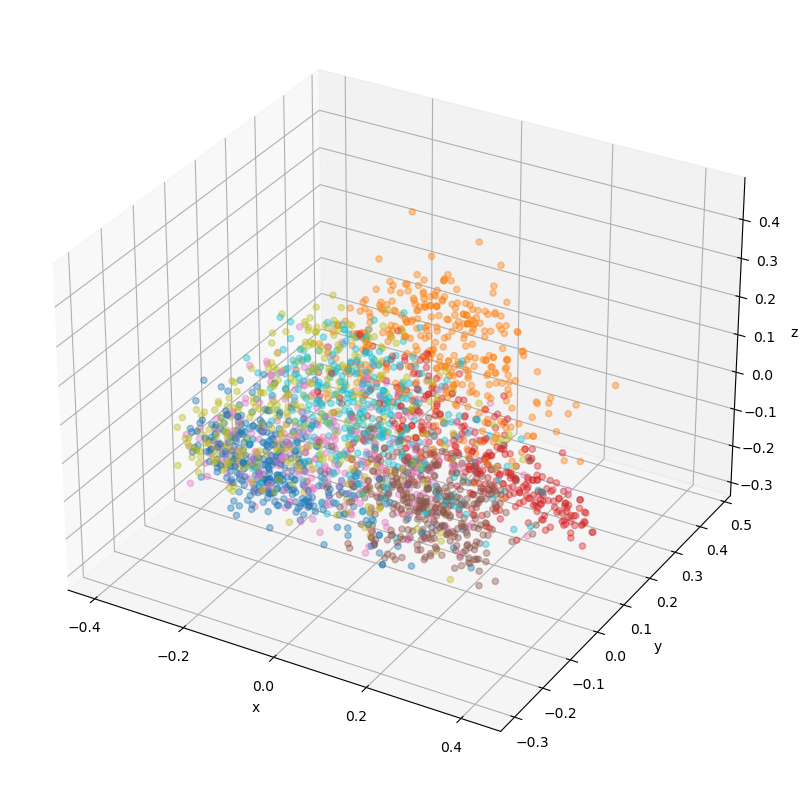

In [244]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_x, 
    ys=pca_y, 
    zs=pca_z, 
    c=Y_test, 
    cmap='tab10',
    alpha=0.4
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Plot Clusters Using TSNE

In [245]:
tsne = TSNE(n_components=2, verbose=1, perplexity=35, n_iter=1000, learning_rate=10)
tsne_results = tsne.fit_transform(X_train)

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 2434 samples in 0.048s...
[t-SNE] Computed neighbors for 2434 samples in 1.114s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2434
[t-SNE] Computed conditional probabilities for sample 2000 / 2434
[t-SNE] Computed conditional probabilities for sample 2434 / 2434
[t-SNE] Mean sigma: 0.127354
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.878006
[t-SNE] KL divergence after 1000 iterations: 1.344770


In [246]:
tsne_x = tsne_results[:,0]
tsne_y = tsne_results[:,1]

## K-means Clusters

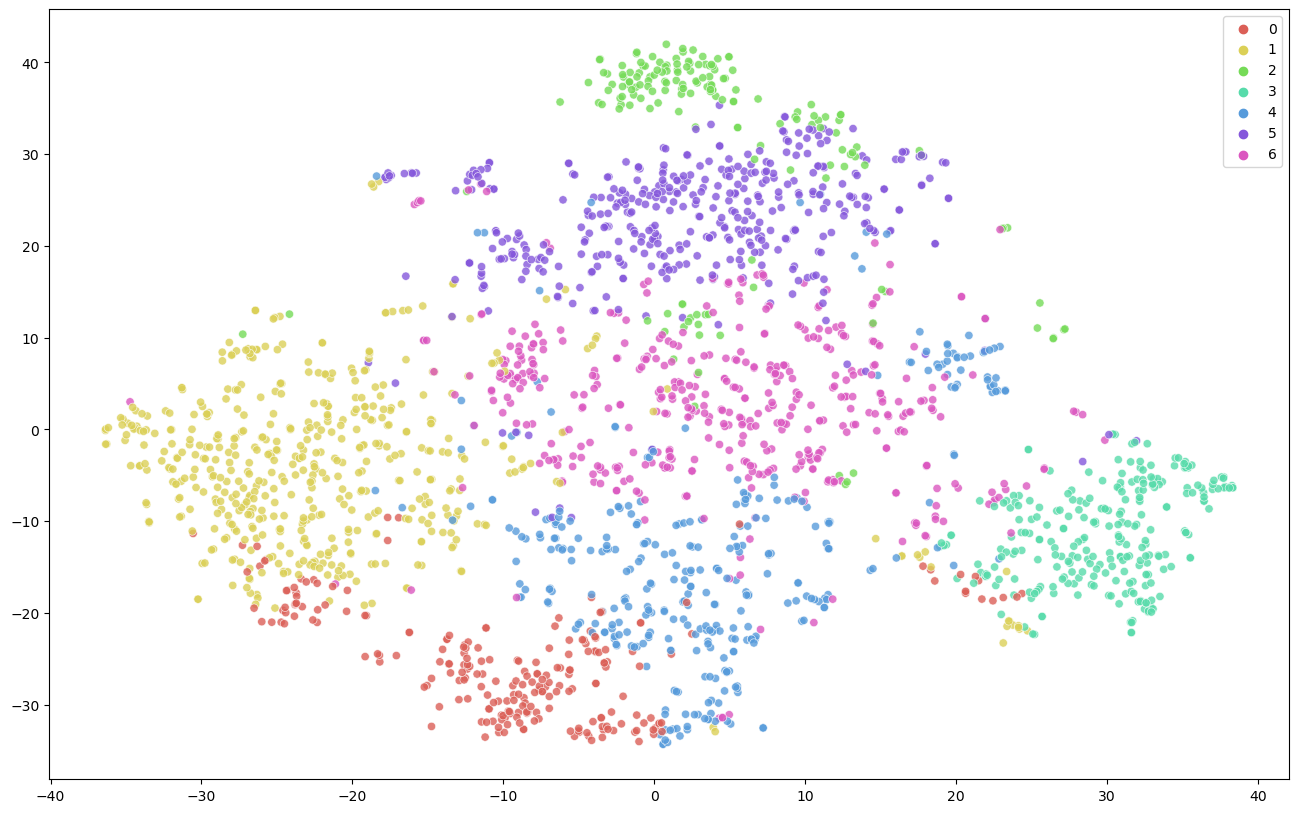

In [247]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_x, y=tsne_y,
    hue=Y_predicted,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)
plt.show()

## Documents True Classes

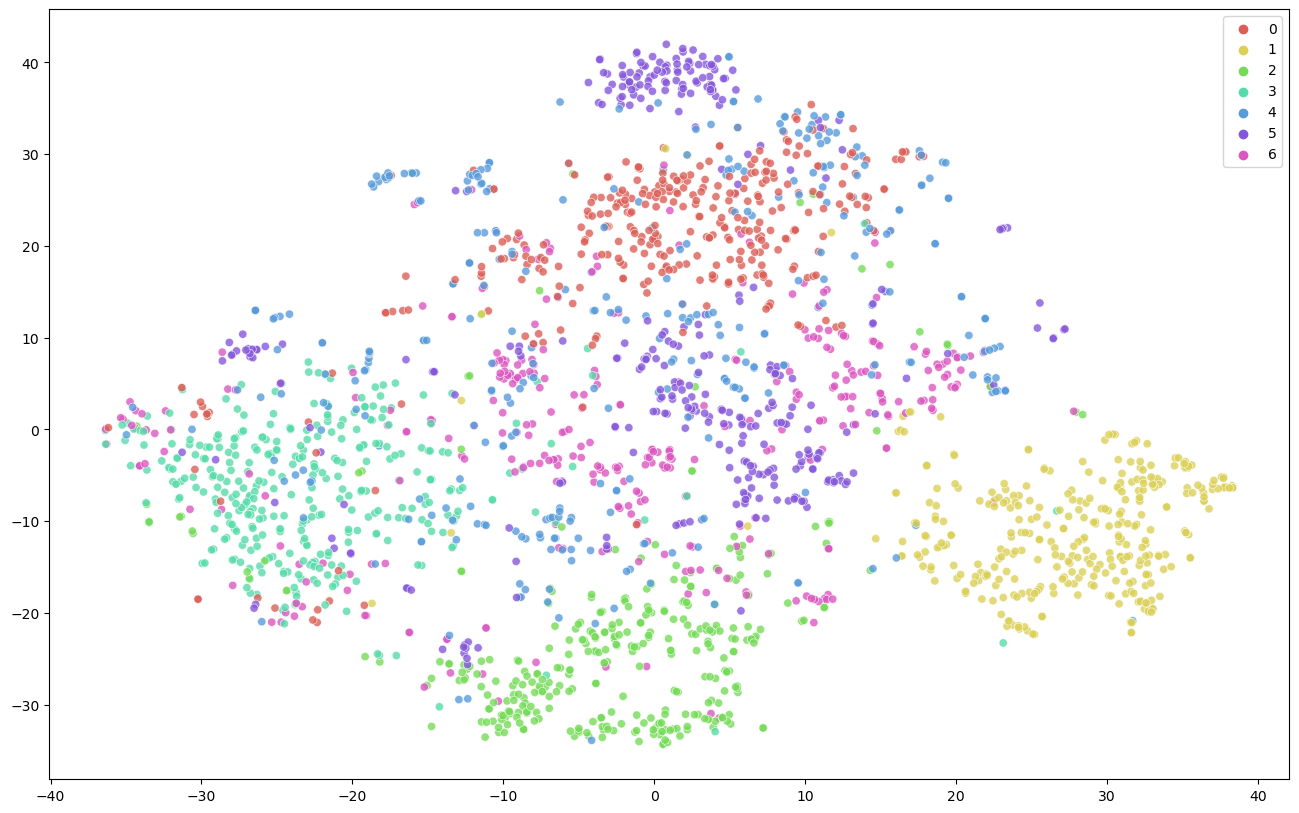

In [248]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_x, y=tsne_y,
    hue=Y_test,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)
plt.show()

# 3D TSNE plot

In [249]:
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000, learning_rate=10)
tsne_results = tsne.fit_transform(X_train)

tsne_x = tsne_results[:,0]
tsne_y = tsne_results[:,1]
tsne_z = tsne_results[:,2]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2434 samples in 0.042s...
[t-SNE] Computed neighbors for 2434 samples in 1.245s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2434
[t-SNE] Computed conditional probabilities for sample 2000 / 2434
[t-SNE] Computed conditional probabilities for sample 2434 / 2434
[t-SNE] Mean sigma: 0.130394
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.860390
[t-SNE] KL divergence after 1000 iterations: 1.128091


## K-means Clusters

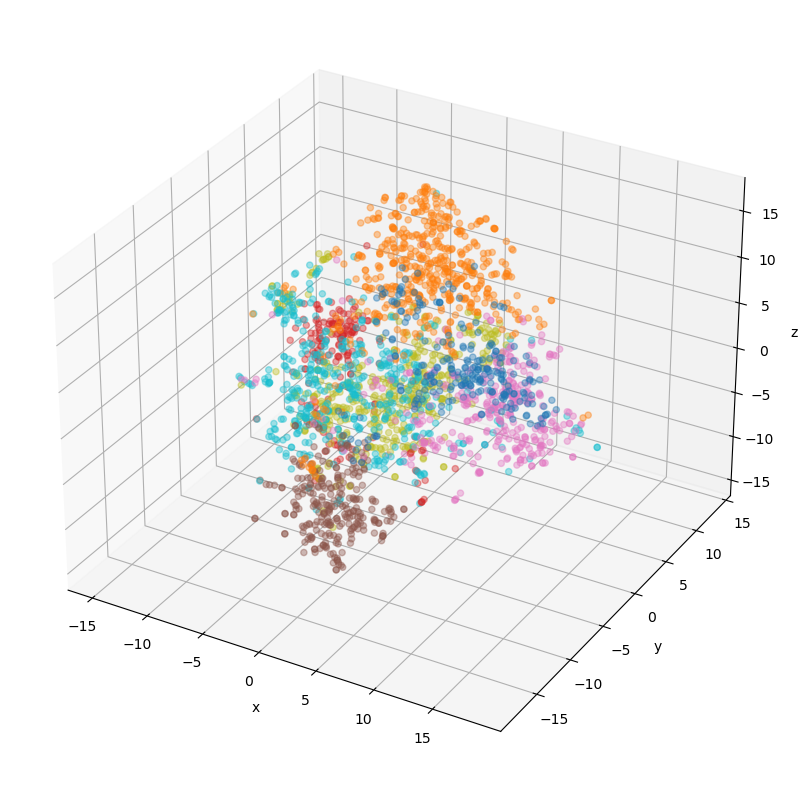

In [250]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=tsne_x, 
    ys=tsne_y, 
    zs=tsne_z, 
    c=Y_predicted, 
    cmap='tab10',
    alpha=0.4
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

## Documents True Classes

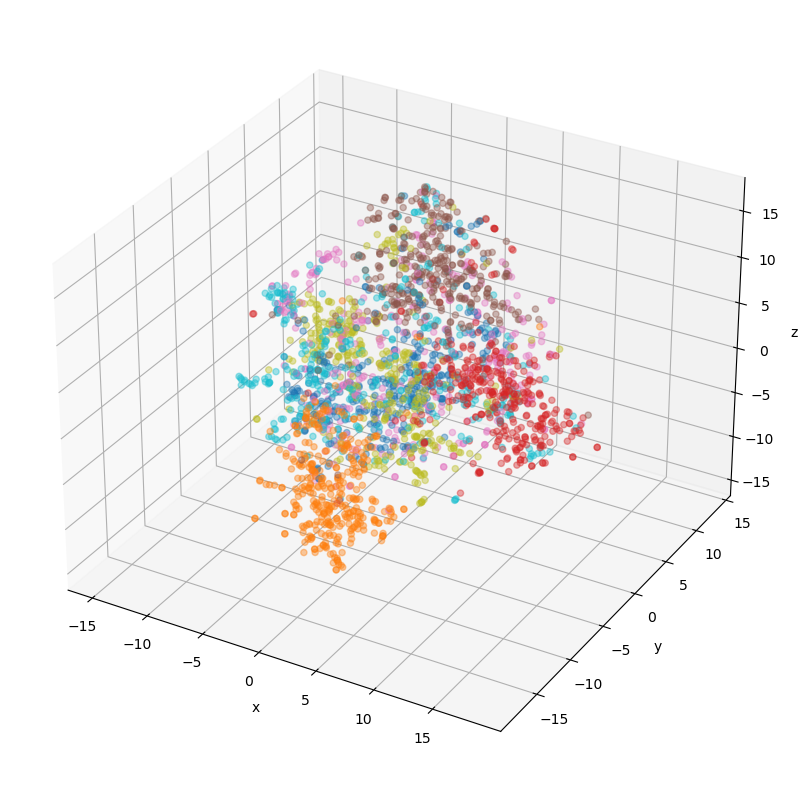

In [251]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=tsne_x, 
    ys=tsne_y, 
    zs=tsne_z, 
    c=Y_test, 
    cmap='tab10',
    alpha=0.4
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# GaussianMixture

In [268]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=7, random_state=0, max_iter=300, n_init=2).fit(X_train)
gm.means_

array([[ 7.83285714e-02,  6.01597053e-02, -4.84397215e-02,
         1.40572340e-02, -1.23977123e-01,  1.35983823e-01,
        -5.27147430e-02, -2.06052134e-01,  2.92359953e-02,
         2.91149740e-02, -2.01320811e-03,  7.77145858e-03,
         8.10736734e-02,  1.30041104e-01, -2.07363816e-02,
        -2.59941223e-02, -8.16222938e-02,  5.30572654e-02,
        -3.59534931e-02,  8.85383482e-03,  5.01984432e-02,
         2.92757821e-02,  1.94438514e-01,  7.31350083e-02,
        -2.37256796e-01,  5.58476173e-02,  3.41336270e-02,
         6.30245749e-02, -2.94744319e-03, -1.28153383e-01,
         3.00535849e-03, -3.50644366e-02, -1.12936319e-02,
         5.04920542e-03,  8.98510441e-02,  6.17062599e-03,
        -7.32743847e-02, -6.72963834e-02,  1.21392915e-02,
         1.50687128e-01,  3.17437745e-02,  4.59983475e-02,
         3.32204846e-04,  1.72137758e-01,  1.50153134e-01,
         1.55392000e-01, -4.47979900e-02,  2.05234555e-02,
         3.10144415e-02, -1.60907560e-03,  1.45609005e-0

In [269]:
Y_predicted = gm.predict(X_train)

In [270]:
labels, count = np.unique(y_predicted, return_counts=True)
labels, count

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([171, 335, 270, 355, 317, 515, 471], dtype=int64))

# Calculate Davies Bouldin Score

In [271]:
davies_bouldin_score(X_train, Y_predicted)

2.248817503086632

# Calculate Silhouette Score

In [272]:
metrics.silhouette_score(X_train, Y_predicted)

0.13026075473304582

# Calculate Purity Score

In [273]:
def purity_score(y_true, y_pred):
    contin_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contin_matrix, axis=0)) / np.sum(contin_matrix) 

In [274]:
purity_score(Y_test, Y_predicted)

0.5990139687756779

# Plot Clusters Using PCA

In [275]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train)

pca_x = pca_result[:,0]
pca_y = pca_result[:,1] 

## GaussianMixture Clusters

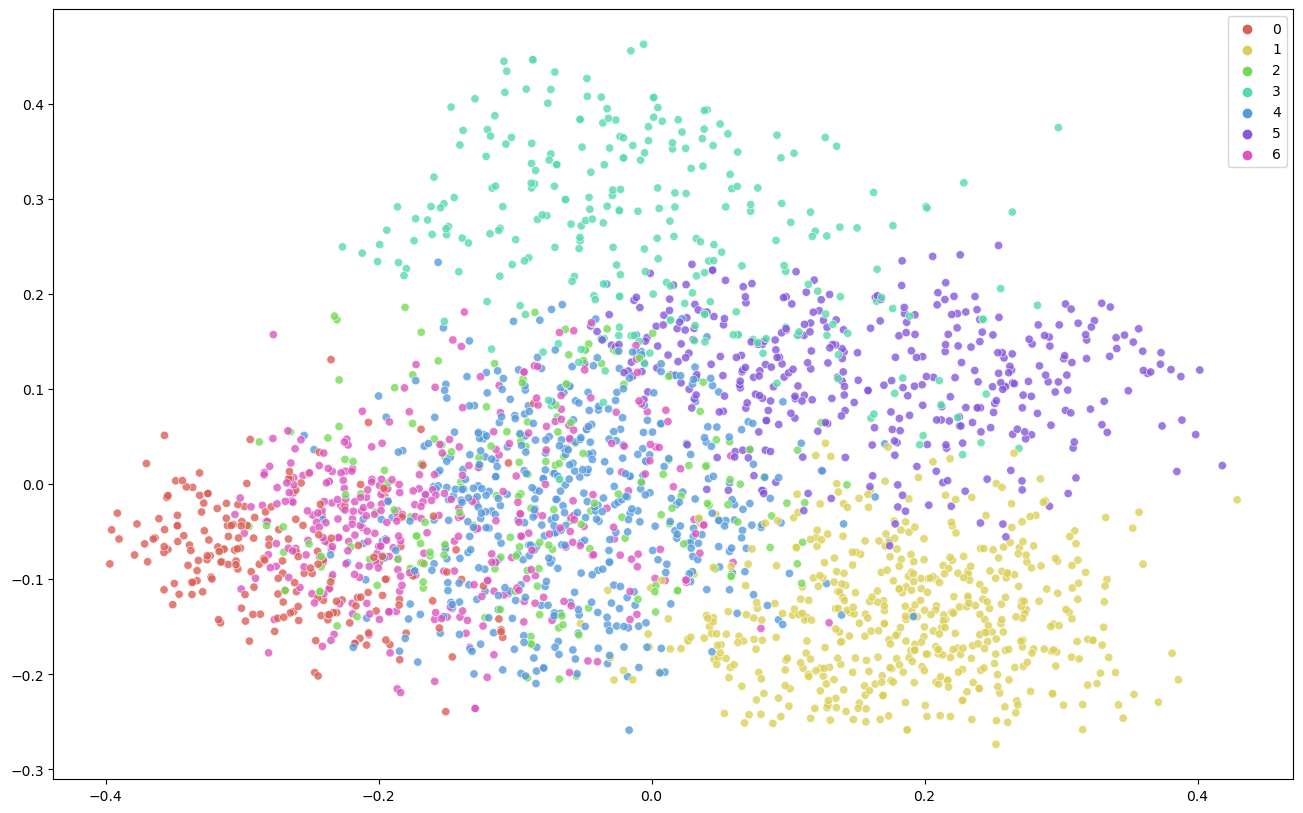

In [276]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=Y_predicted,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)
plt.show()

## Documents True Classes

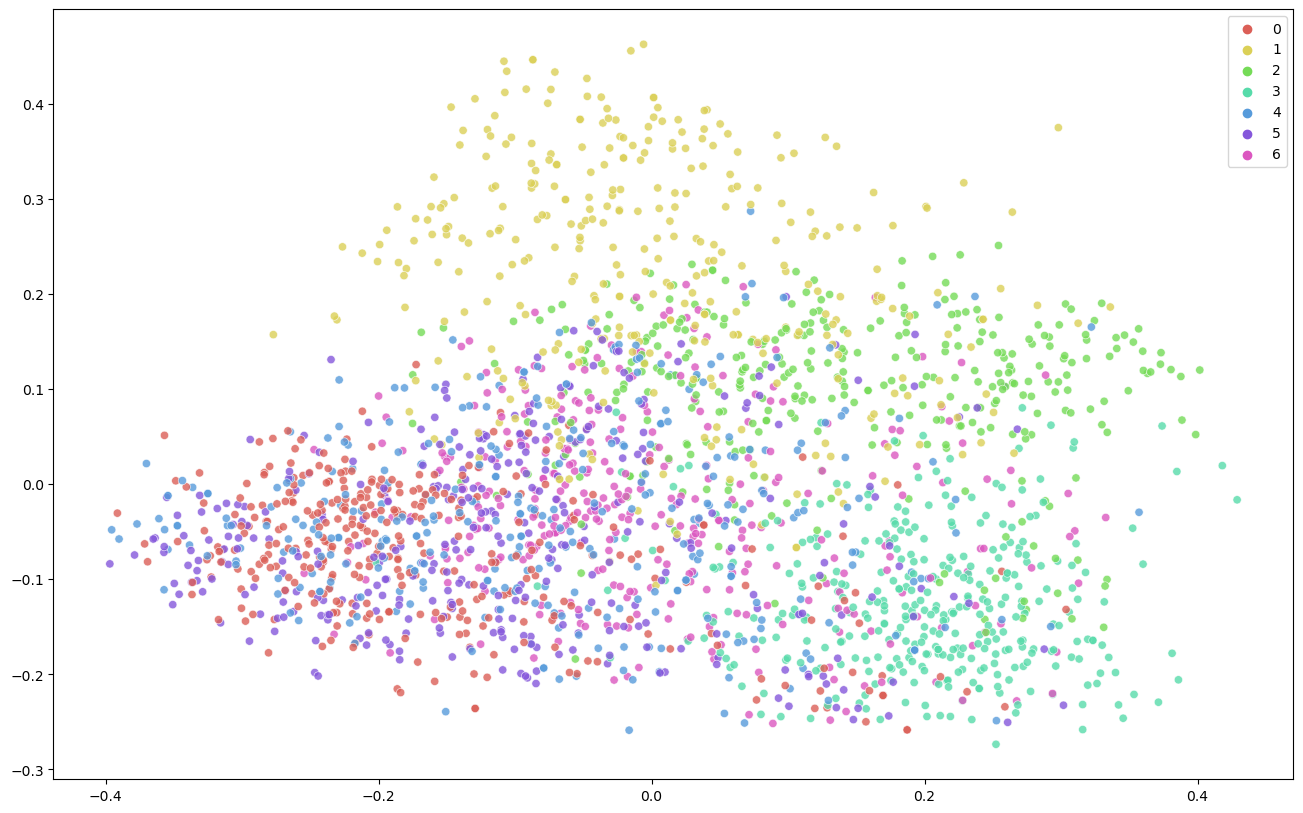

In [277]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=Y_test,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)
plt.show()

# Birch

In [284]:
from sklearn.cluster import Birch
brc = Birch(n_clusters=7, threshold=0.1)
brc.fit(X_train)

Birch(n_clusters=7, threshold=0.1)

In [285]:
Y_predicted = brc.predict(X_train)

In [286]:
labels, count = np.unique(Y_predicted, return_counts=True)
labels, count

(array([0, 1, 2, 3, 4, 5, 6], dtype=int64),
 array([583, 286, 525, 242, 266, 243, 289], dtype=int64))

# Calculate Davies Bouldin Score

In [287]:
davies_bouldin_score(X_train, Y_predicted)

2.687786663969246

# Calculate Silhouette Score

In [288]:
metrics.silhouette_score(X_train, Y_predicted)

0.1115866986426148

# Calculate Purity Score

In [289]:
def purity_score(y_true, y_pred):
    contin_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contin_matrix, axis=0)) / np.sum(contin_matrix) 

In [290]:
purity_score(Y_test, Y_predicted)

0.6121610517666393

# Plot Clusters Using PCA

In [291]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_train)

pca_x = pca_result[:,0]
pca_y = pca_result[:,1] 

## K-means Clusters

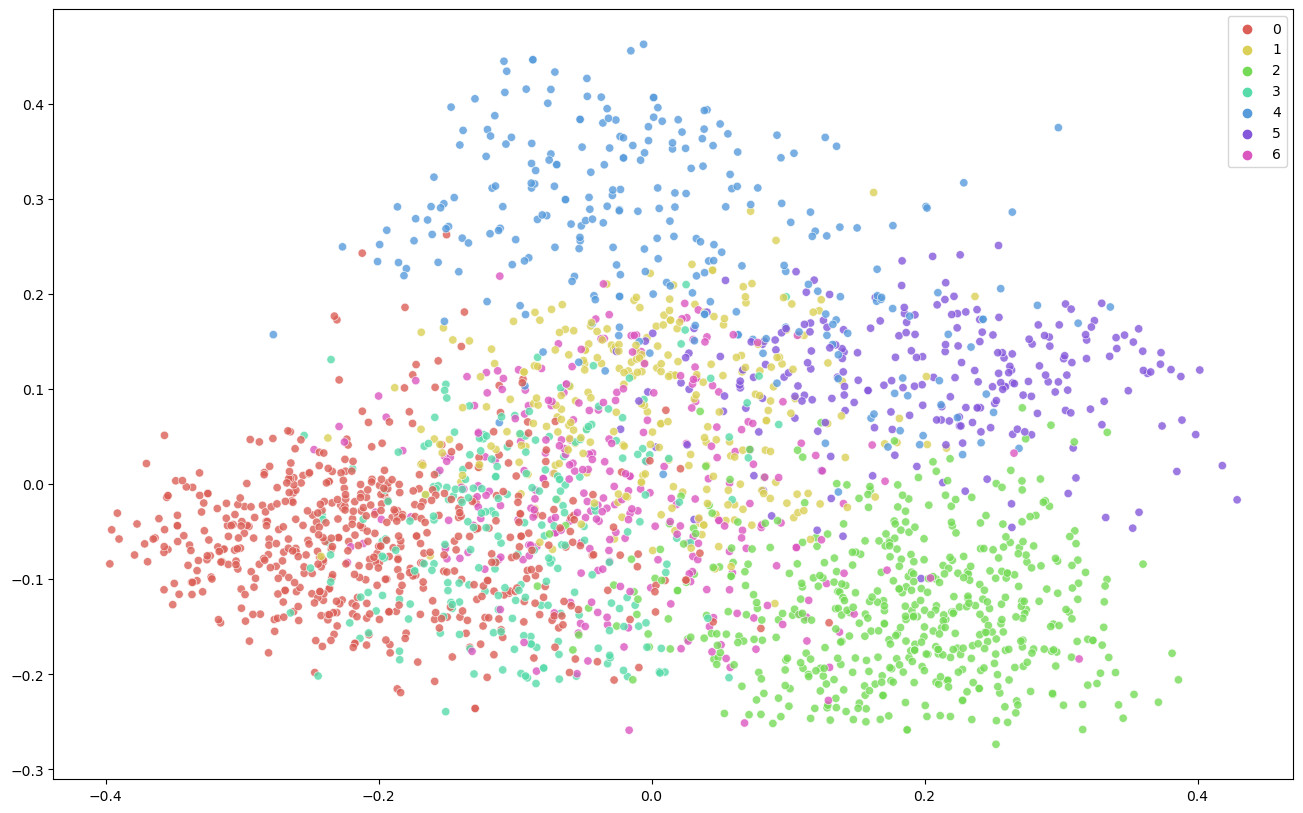

In [292]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=Y_predicted,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)
plt.show()

## Documents True Classes

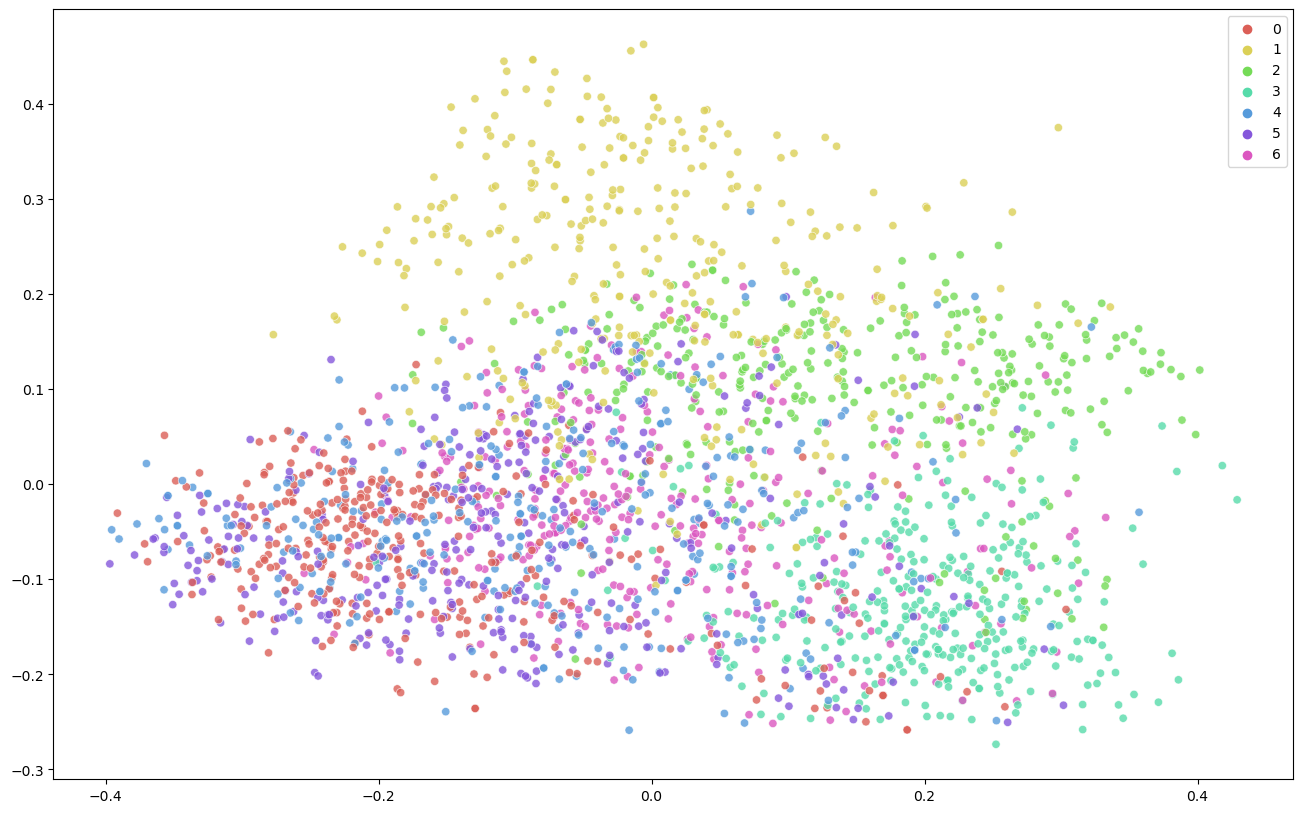

In [293]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_x, y=pca_y,
    hue=Y_test,
    palette=sns.color_palette("hls", 7),
    legend="full",
    alpha=0.8
)
plt.show()